<a href="https://colab.research.google.com/github/Song-Pingfan/fastMRI/blob/spf/fastMRI_tutorial_spf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [ ]:
# Check if we're running in Colab (versus local server)

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab.")
else:
  print("We're running in a local server.")


We're running Colab.


In [ ]:
%pwd

'/content'

In [ ]:
# If we're in Colab, mount the Google Drive, and switch to a directory that will be used,
# else we're not in Colab, get current working directory, and switch to a directory that will be used.

if IN_COLAB:
  # Mount the Google Drive (if we're in Colab)
  mount='/content/googledrive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount) # drive.flush_and_unmount() # unmount google drive

  # Switch to a directory that will be used.
  import os
  ROOT = mount + "/MyDrive/Research/fastMRI-MetaAI"

else:
  # Get current working directory (if we're not in Colab)
  mount = '/homes/ps898' # mount = os.getcwd(), # os.path.dirname(ROOT) gives '/homes'
  
  # Switch to a directory that will be used.
  import os
  ROOT = mount + "/googledrive/Research/fastMRI-MetaAI"


# # Create ROOT if it doesn't exist
# os.makedirs(ROOT, exist_ok=True)

# Change to the directory
print("\nColab: Changing directory to ", ROOT)
%cd $ROOT


Colab: mounting Google drive on  /content/googledrive
Mounted at /content/googledrive

Colab: Changing directory to  /content/googledrive/MyDrive/Research/fastMRI-MetaAI
/content/googledrive/MyDrive/Research/fastMRI-MetaAI


In [ ]:
%ls

banding_removal/      fastmri_examples/           multicoil_train/  setup.py
CODE_OF_CONDUCT.md    fastMRI_tutorial_spf.ipynb  multicoil_val/    tests/
CONTRIBUTING.md       fastMRI_tutorial_spf.pdf    mypy.ini
dev-requirements.txt  LICENSE.md                  README.md
fastmri/              LIST_OF_PAPERS.md           requirements.txt


In [ ]:
import torch
[
torch.cuda.is_available(),
torch.cuda.device_count(),
torch.cuda.current_device(),
torch.cuda.device(0), # <torch.cuda.device at 0x7efce0b03be0>
torch.cuda.get_device_name(0) # 'GeForce GTX 950M'
]

[True, 1, 0, <torch.cuda.device at 0x7fcafaa35990>, 'Tesla T4']

In [ ]:
# check and setup GPU in TF
# # Check whether there is a GPU available.
# import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# print('Found GPU at: {}'.format(device_name))

# # Set GPU resource quota

# # # for TF 1.x
# # os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# # from keras.backend.tensorflow_backend import set_session
# # config = tf.ConfigProto()
# # config.gpu_options.per_process_gpu_memory_fraction = 0.7
# # set_session(tf.Session(config=config))

# # for TF 2.x
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#             # tf.config.experimental.set_virtual_device_configuration(gpus[0], [
#             #     tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
#     except RuntimeError as e:
#         print(e)

Found GPU at: /device:GPU:0


#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [ ]:
# Testing if integration works

In [ ]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

The fastMRI dataset is distributed as a set of HDF5 files and can be read with the h5py package. Here, we show how to open a file from the multi-coil dataset. Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

In [ ]:
file_name = 'multicoil_train/file1000167.h5'
hf = h5py.File(file_name)

In [ ]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'reconstruction_rss']
Attrs: {'acquisition': 'CORPDFS_FBK', 'max': 0.0001939351360000761, 'norm': 0.03873648065532312, 'patient_id': '85e5050fe8a675edc7a4e7a640355b99d39ad209e77f4f978326f842a0cef337'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [ ]:
# spf
# why not assign as volume_kspace =  hf['kspace']
# hf['kspace'].shape gives (30, 15, 640, 372)

(30, 15, 640, 372)

In [ ]:
volume_kspace = hf['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(30, 15, 640, 372)


In [ ]:
slice_kspace = volume_kspace[20] # Choosing the 20-th slice of this volume

Let's see what the absolute value of k-space looks like:

In [ ]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

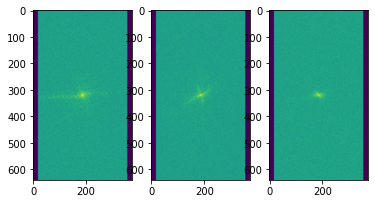

In [ ]:
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [ ]:
# install fastmri if we are using colab.
if IN_COLAB:
    %pip install fastmri

In [ ]:
import fastmri
from fastmri.data import transforms as T

In [ ]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

In [ ]:
slice_kspace.shape, slice_kspace2.shape, slice_image.shape, slice_image_abs.shape

((15, 640, 372),
 torch.Size([15, 640, 372, 2]),
 torch.Size([15, 640, 372, 2]),
 torch.Size([15, 640, 372]))

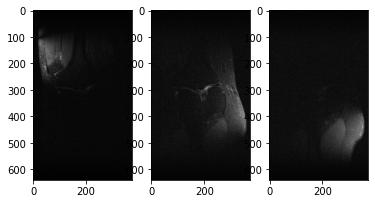

In [ ]:
show_coils(slice_image_abs, [0, 5, 10], cmap='gray')

As we can see, each coil in a multi-coil MRI scan focusses on a different region of the image. These coils can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [ ]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

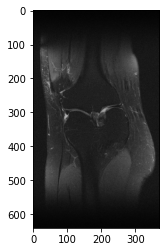

In [ ]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [ ]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [ ]:
help(mask_func)

In [ ]:
help(T.apply_mask)

In [ ]:
# T.apply_mask returns 3 variables: masked data, mask and num_low_frequencies.
masked_kspace, mask, num_low_frequencies = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

In [ ]:
masked_kspace.shape, mask.shape, num_low_frequencies

(torch.Size([15, 640, 372, 2]), torch.Size([1, 1, 372, 1]), 15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  after removing the cwd from sys.path.


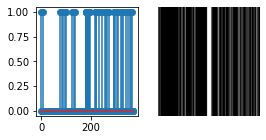

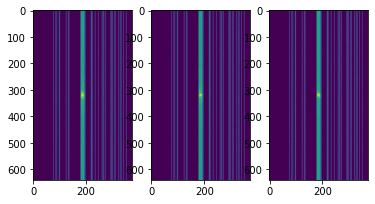

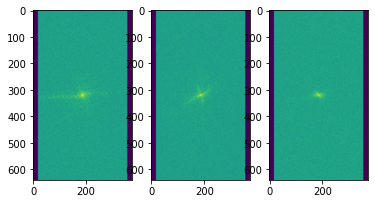

In [ ]:
# show mask - spf
plt.figure(figsize=(4,2))
plt.subplot(1,2,1)
plt.stem( np.squeeze(mask.numpy()))
plt.subplot(1,2,2)
plt.imshow(np.squeeze(mask.numpy(),axis=(0,3)), aspect='auto', cmap='gray')
plt.axis('off')
# plt.colorbar()
plt.show()

# show masked kspace
masked_kspace_abs = fastmri.complex_abs(masked_kspace)   # Compute absolute value to get a real image
show_coils(np.log(masked_kspace_abs + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

# show fully-sampled kspace
show_coils(np.log(np.abs(slice_kspace) + 1e-9), [0, 5, 10])  # This shows coils 0, 5 and 10

Let's see what the subsampled image looks like:

In [ ]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

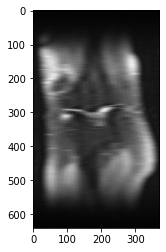

In [ ]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')